TextCNN+bn 模型。dropout=0.8 最后还是过拟合了，效果并没有比 dropout=0.5 好。

参考代码： 

https://github.com/brightmart/text_classification/blob/master/a02_TextCNN/p7_TextCNN_model.py 

https://github.com/Qinbf/Tensorflow/blob/master/Tensorflow%E5%9F%BA%E7%A1%80%E4%BD%BF%E7%94%A8%E4%B8%8E%E6%96%87%E6%9C%AC%E5%88%86%E7%B1%BB%E5%BA%94%E7%94%A8/%E7%A8%8B%E5%BA%8F/cnn.ipynb

- 每个模型保存到对应的模型位置
- 每个模型生成一个 scores 分数矩阵用于后面进行模型融合

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from gensim.models import KeyedVectors
import pickle
import os
import sys
import shutil
import time


time0 = time.time()
print('Starting ...')
model_name = 'textcnn-title-256-len50'                    # 模型名称
W_embedding = np.load('../data/W_embedding.npy')            # 导入预训练好的词向量
model_path = '../ckpt/' + model_name + '/'                  # 模型保存位置
summary_path = '../summary/' + model_name + '/'             # summary 位置
result_path = '../result/' + model_name + '.csv'            # result.csv 位置
scores_path = '../scores/' + model_name + '.npy'            # scores.npy 位置

if not os.path.exists(model_path):
    os.makedirs(model_path)         
model_path = model_path + 'model.ckpt'
if os.path.exists(summary_path):   # 删除原来的 summary 文件，避免重合
    print('removed the existing summary files.')
    shutil.rmtree(summary_path)
os.makedirs(summary_path)          # 然后再次创建
    
# ##################### config ######################
n_step = max_len = 50                   # 句子长度
input_size = embedding_size = 256       # 字向量长度
n_class = 1999                          # 类别总数
filter_sizes = [3,4,5]                  # 卷积核大小
n_filter = 256                          # 每种卷积核的个数
n_filter_total = n_filter * len(filter_sizes)
global_step = 0
valid_num = 300000
seed_num = 13
print('Prepared, costed time %g s.' % (time.time() - time0))

Starting ...
removed the existing summary files.
Prepared, costed time 0.768948 s.


In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from tensorflow.contrib import rnn
import tensorflow.contrib.layers as layers

'''
双端 GRU，知乎问题多标签分类。
'''
print('Building model ...')
lr = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32, [])
batch_size = tf.placeholder(tf.int32, [])  # 注意类型必须为 tf.int32
tst = tf.placeholder(tf.bool)
n_updates = tf.placeholder(tf.int32)      # training iteration,传入 bn 层
update_emas = list()   # BN 层中所有的更新操作


def weight_variable(shape, name):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def batchnorm(Ylogits, is_test, num_updates, offset, convolutional=False):
    """batchnormalization.
    Args:
        Ylogits: 1D向量或者是3D的卷积结果。
        num_updates: 迭代的global_step
        offset：表示beta，全局均值；在 RELU 激活中一般初始化为 0.1。
        scale：表示lambda，全局方差；在 sigmoid 激活中需要，这 RELU 激活中作用不大。
        m: 表示batch均值；v:表示batch方差。
        bnepsilon：一个很小的浮点数，防止除以 0.
    Returns:
        Ybn: 和 Ylogits 的维度一样，就是经过 Batch Normalization 处理的结果。
        update_moving_everages：更新mean和variance，主要是给最后的 test 使用。
    """
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.999, num_updates) # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    if convolutional:
        mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
    update_moving_everages = exp_moving_avg.apply([mean, variance])
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
    return Ybn, update_moving_everages


with tf.name_scope('Inputs'):
    X_inputs = tf.placeholder(tf.int64, [None, n_step], name='X_input')
    y_inputs = tf.placeholder(tf.float32, [None, n_class], name='y_input')    

with tf.name_scope('embedding_layer'):
    embedding = tf.get_variable(name="W_embedding", shape=W_embedding.shape, 
                        initializer=tf.constant_initializer(W_embedding), trainable=True)   # fine-tune

def textcnn(X_inputs):
    """build the TextCNN network. Return the h_drop"""
    # X_inputs.shape = [batchsize, n_step]  ->  inputs.shape = [batchsize, n_step, embedding_size]
    inputs = tf.nn.embedding_lookup(embedding, X_inputs)  
    inputs = tf.expand_dims(inputs, -1)
    pooled_outputs = list()
    for i, filter_size in enumerate(filter_sizes):
        with tf.name_scope("conv-maxpool-%s" % filter_size):
            # Convolution Layer
            filter_shape = [filter_size, embedding_size, 1, n_filter]
            W_filter = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W_filter")
            tf.summary.histogram('W_filter', W_filter)
#             b_filter = tf.Variable(tf.constant(0.1, shape=[n_filter]), name="b_filter")   # 使用 offset，就不用 biases了
#             tf.summary.histogram('b_filter', b_filter)
            beta = tf.Variable(tf.constant(0.1, tf.float32, shape=[n_filter], name="beta"))
            tf.summary.histogram('beta', beta)
            conv = tf.nn.conv2d(inputs, W_filter, strides=[1, 1, 1, 1], padding="VALID", name="conv")
            conv_bn, update_ema = batchnorm(conv, tst, n_updates, beta, convolutional=True)    # 在激活层前面加 BN
            # Apply nonlinearity
            # batch norm scaling is not useful with relus
            # batch norm offsets are used instead of biases,使用 BN 层的 offset，不要 biases
            h = tf.nn.relu(conv_bn, name="relu")
            # Maxpooling over the outputs
            pooled = tf.nn.max_pool(h,ksize=[1, n_step - filter_size + 1, 1, 1],
                strides=[1, 1, 1, 1],padding='VALID',name="pool")
            pooled_outputs.append(pooled)
            update_emas.append(update_ema)
    h_pool = tf.concat(pooled_outputs, 3)
    h_pool_flat = tf.reshape(h_pool, [-1, n_filter_total])
    with tf.name_scope('dropout'):
        h_drop = tf.nn.dropout(h_pool_flat, keep_prob)  # h_drop.shape = [-1, num_filters_total]
    return h_drop     

with tf.name_scope('textcnn'):
    h_drop = textcnn(X_inputs)
    
with tf.name_scope('out_layer'):
    W_out = weight_variable([n_filter_total, n_class], name='Weight_out') 
    tf.summary.histogram('Weight_out', W_out)
    b_out = bias_variable([n_class], name='bias_out') 
    tf.summary.histogram('bias_out', b_out)
    y_pred = tf.nn.xw_plus_b(h_drop, W_out, b_out, name='y_pred')  #每个类别的分数 scores
with tf.name_scope('cost'):
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y_inputs))
    tf.summary.scalar('cost', cost)

# 优化器
with tf.name_scope('AdamOptimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    train_op = optimizer.minimize(cost)
    update_op = tf.group(*update_emas)   # 更新 BN 参数

# summary
merged = tf.summary.merge_all() # summary
train_writer = tf.summary.FileWriter(summary_path + 'train', sess.graph)
test_writer = tf.summary.FileWriter(summary_path + 'test')
print 'Finished creating the TextCNN model.'

Building model ...
Finished creating the TextCNN model.


## 导入数据

In [3]:
sys.path.append('..')
from data_helpers import BatchGenerator
from data_helpers import to_categorical
from evaluator import score_eval

print 'loading data ...'
time0 = time.time()
save_path = '../data/'
X = np.load(save_path+'X_tr_title_50.npy')
y = np.load(save_path+'y_tr.npy')
# 划分验证集
sample_num = X.shape[0]
np.random.seed(seed_num)
new_index = np.random.permutation(sample_num)
X = X[new_index]
y = y[new_index]
X_valid = X[:valid_num]
# y_valid = y[:valid_num]
# X_train = X[valid_num:]
# y_train = y[valid_num:]
# print('train_num=%d, valid_num=%d' % (X_train.shape[0], X_valid.shape[0]))
# # 构建数据生成器
# data_train = BatchGenerator(X_train, y_train, shuffle=True)
# data_valid = BatchGenerator(X_valid, y_valid, shuffle=False)
# print('X_train.shape=', X_train.shape, 'y_train.shape=', y_train.shape)
# print('X_valid.shape=', X_valid.shape, 'y_valid.shape=', y_valid.shape)

# # valid 数据及 验证集计算
# marked_labels_list = data_valid.y.tolist() # 所有的标注结果
# valid_data_size = data_valid.y.shape[0]
# def valid_epoch():
#     """Testing or valid."""
#     data_valid._index_in_epoch = 0  # 先指向第一个值
#     _batch_size = 4000
#     fetches = [merged, cost, y_pred]   
#     batch_num = int(valid_data_size / _batch_size)
#     start_time = time.time()
#     _costs = 0.0
#     predict_labels_list = list()  # 所有的预测结果
#     for i in xrange(batch_num):
#         X_batch, y_batch = data_valid.next_batch(_batch_size)
#         y_batch = to_categorical(y_batch)
#         feed_dict = {X_inputs:X_batch, y_inputs:y_batch, lr:1e-5, batch_size:_batch_size, keep_prob:1.0, tst:True, n_updates:global_step}
#         summary, _cost, predict_labels = sess.run(fetches, feed_dict)
#         _costs += _cost    
#         predict_labels = map(lambda label: label.argsort()[-1:-6:-1], predict_labels) # 取最大的5个下标
#         predict_labels_list.extend(predict_labels)
#     test_writer.add_summary(summary, global_step)
#     predict_label_and_marked_label_list = zip(predict_labels_list, marked_labels_list)
#     precision, recall, f1 = score_eval(predict_label_and_marked_label_list)
#     mean_cost = _costs / batch_num
#     return mean_cost, precision, recall, f1

# print('Finised loading data, time %g s' % (time.time() - time0))

loading data ...


##  模型训练

In [4]:
tr_batch_size = 256      
_lr = 1.5e-3 
max_epoch = 2            # 超多 max_epoch 以后开始降低 lr
decay = 0.65             # 每个 epoch lr降低的系数
valid_step = 6000        # 每 valid_step 就进行一次 valid 运算
max_max_epoch = 8       # 最多迭代的次数
save_epoch = 1           # 每迭代 save_epoch 次保存一次模型
tr_batch_num = int(data_train.y.shape[0] / tr_batch_size)  # 每个 epoch 中包含的 batch 数
saver = tf.train.Saver(max_to_keep=12)           # 最多保存的模型数量
sess.run(tf.global_variables_initializer())

for epoch in xrange(max_max_epoch):
    fetches = [merged, cost, train_op, update_op]
    if (epoch >= max_epoch):
        _lr = _lr * decay
    print 'EPOCH %d， lr=%g' % (epoch+1, _lr)
    time0 = time.time()
    start_time = time.time()
    _costs = 0.0
    show_costs = 0.0
    for batch in xrange(tr_batch_num): 
        global_step += 1
        if (batch+1) % valid_step == 0:    # 进行 valid 计算
            valid_cost, precision, recall, f1 = valid_epoch()
            print('global_step=%d: valid cost=%g; p=%g, r=%g, f1=%g ' % (
                    global_step, valid_cost, precision, recall, f1))
        X_batch, y_batch = data_train.next_batch(tr_batch_size)
        y_batch = to_categorical(y_batch)
        feed_dict = {X_inputs:X_batch, y_inputs:y_batch, lr:_lr, batch_size:tr_batch_size, keep_prob:0.5, tst:False, n_updates:global_step}
        summary, _cost, _, _ = sess.run(fetches, feed_dict) # the cost is the mean cost of one batch
        _costs += _cost
        if global_step % 100:
            train_writer.add_summary(summary, global_step)
    valid_cost, precision, recall, f1 = valid_epoch()  # # 每个 epoch 进行一次验证 valid
    mean_cost = _costs / tr_batch_num
    print('training cost=%g; valid cost=%g; p=%g, r=%g, f1=%g; speed=%g s/epoch' % (
        mean_cost, valid_cost, precision, recall, f1, time.time()-time0) )
    if (epoch + 1) % save_epoch == 0:  # 每 2 个 epoch 保存一次模型
        save_path = saver.save(sess, model_path, global_step=(epoch+1))
        print('the save path is ', save_path) 

EPOCH 1， lr=0.0015
global_step=6000: valid cost=0.00674229; p=1.0896, r=0.444565, f1=0.31574 
training cost=0.00804923; valid cost=0.00737677; p=1.165, r=0.475192, f1=0.337521; speed=1398.45 s/epoch
('the save path is ', '../ckpt/textcnn-title-256-len50/model.ckpt-1')
EPOCH 2， lr=0.0015
global_step=16546: valid cost=0.00528478; p=1.25022, r=0.509573, f1=0.362019 
training cost=0.00497216; valid cost=0.00482294; p=1.28017, r=0.521182, f1=0.370389; speed=1339.08 s/epoch
('the save path is ', '../ckpt/textcnn-title-256-len50/model.ckpt-2')
EPOCH 3， lr=0.000975
global_step=27092: valid cost=0.00452673; p=1.30917, r=0.533035, f1=0.378803 
training cost=0.00464207; valid cost=0.00471893; p=1.30846, r=0.532823, f1=0.378636; speed=1370.89 s/epoch
('the save path is ', '../ckpt/textcnn-title-256-len50/model.ckpt-3')
EPOCH 4， lr=0.00063375
global_step=37638: valid cost=0.00439226; p=1.33039, r=0.541538, f1=0.384874 
training cost=0.00446273; valid cost=0.00438631; p=1.33423, r=0.543007, f1=0.385

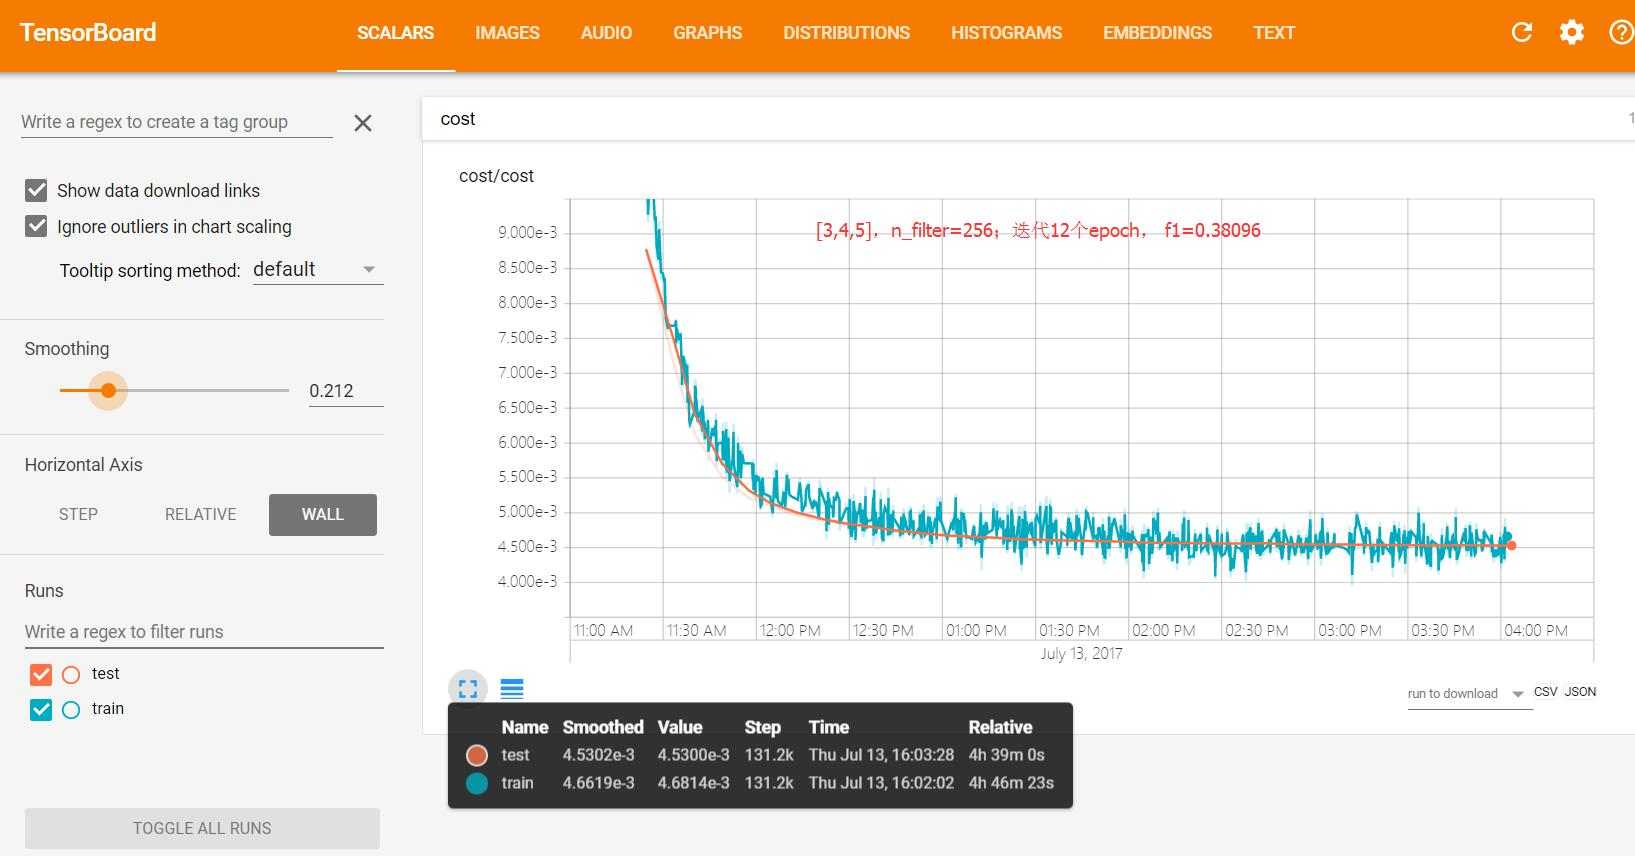

In [5]:
from IPython.display import Image
Image('../figs/cnn-title-256.jpg')   # 结果保存了时间步。。。看个屁

- Bi-LSTM 模型<br/>
**batch_size=256，迭代12个epoch，基本收敛。结果： 验证集 f1=0.38618； 提交结果 0.3873186**
- Bi-GRU 模型<br/>
**batch_size=256，迭代15个epoch。大概在 13 个 epoch 就收敛了。结果： 验证集 f1=0.390534； 提交结果 0.39198**
- attention-Bi-GRU 模型<br/>
**batch_size=256，迭代18个epoch。在16个epoch收敛。结果：验证集 f1=f1=0.391734 ；提交结果 0.39310**


- textcnn-256 lr=1e-3, decay=0.65, dropout=0.5, 迭代6次基本收敛， f1=0.388
- textcnn-256-bn lr=1.5E-3，decay=0.65, dropout=0.5, 6次基本收敛，8次好一点， f1=0.389

## 若没有收敛，继续迭代

In [11]:
_lr=2e-4
global_step=50185
add_epoch = 2   # 增加迭代的次数
for epoch in xrange(max_max_epoch,max_max_epoch+add_epoch):
    fetches = [merged, cost, train_op]
    _lr = _lr * decay
    print 'EPOCH %d， lr=%g' % (epoch+1, _lr)
    time0 = time.time()
    start_time = time.time()
    _costs = 0.0
    show_costs = 0.0
    for batch in xrange(tr_batch_num): 
        global_step += 1
        if (batch+1) % valid_step == 0:    # 进行 valid 计算
            valid_cost, precision, recall, f1 = valid_epoch()
            print('global_step=%d: valid cost=%g; p=%g, r=%g, f1=%g ' % (
                    global_step+1, valid_cost, precision, recall, f1))
        X_batch, y_batch = data_train.next_batch(tr_batch_size)
        y_batch = to_categorical(y_batch)
        feed_dict = {X_inputs:X_batch, y_inputs:y_batch, lr:_lr, batch_size:tr_batch_size, keep_prob:0.5, tst:False, n_updates:global_step}
        summary, _cost, _ = sess.run(fetches, feed_dict) # the cost is the mean cost of one batch
        _costs += _cost
        if global_step % 100:
            train_writer.add_summary(summary, global_step)
    valid_cost, precision, recall, f1 = valid_epoch()  # # 每个 epoch 进行一次验证 valid
    mean_cost = _costs / tr_batch_num
    print('training cost=%g; valid cost=%g; p=%g, r=%g, f1=%g; speed=%g s/epoch' % (
        mean_cost, valid_cost, precision, recall, f1, time.time()-time0) )
    if (epoch + 1) % save_epoch == 0:  # 每 2 个 epoch 保存一次模型
        save_path = saver.save(sess, model_path, global_step=(epoch+1))
        print('the save path is ', save_path) 

EPOCH 6， lr=1.34627e-05


TypeError: Cannot interpret feed_dict key as Tensor: Can not convert a float into a Tensor.

In [10]:
# 导入保存好的模型
saver = tf.train.Saver()
best_model_path = model_path + '-' + str(5)  # 导入最优模型
saver.restore(sess, best_model_path)
print('Finished loading model.')

INFO:tensorflow:Restoring parameters from ../ckpt/textcnn-title-256/model.ckpt-5
Finished loading model.


## 本地预测

In [4]:
sys.path.append('..')
from evaluator import score_eval

print('begin ...')
# 保存 本地测试的标注数据
marked_labels_list = np.load('../data/marked_labels_list.npy')
local_scores_path = '../local_scores/' + model_name + '.npy'

# 导入保存好的模型
saver = tf.train.Saver()
best_model_path = model_path + '-' + str(8)  # 导入最优模型
saver.restore(sess, best_model_path)
print('Finished loading model.')

begin ...
INFO:tensorflow:Restoring parameters from ../ckpt/textcnn-title-256-len50/model.ckpt-8
Finished loading model.


In [6]:
# 导入测试数据
def local_predict(scores_path=local_scores_path):
    """预测  valid 结果，并保存预测概率 到  scores.csv 文件中。"""
    print('local predicting ...')
    time0 = time.time()
    X_te = X_valid[:100000, :]
    n_sample = X_te.shape[0]  # 测试样本数量
    _batch_size = 100
    fetches = [y_pred]   
    predict_labels_list = list()  # 所有的预测结果
    predict_scores = list()
    for i in xrange(0, n_sample, _batch_size):
        start = i
        end = start+_batch_size
        if end > n_sample:
            end = n_sample
            _batch_size = end - start
        X_batch = X_te[start:end]
        feed_dict = {X_inputs:X_batch, lr:1e-5,
                     batch_size:_batch_size, keep_prob:1.0, tst:True, n_updates:global_step}
        predict_labels = sess.run(fetches, feed_dict)[0]
        predict_scores.append(predict_labels)
        predict_labels = map(lambda label: label.argsort()[-1:-6:-1], predict_labels) # 取最大的5个下标
        predict_labels_list.extend(predict_labels)
    predict_scores = np.asarray(predict_scores)
    predict_label_and_marked_label_list = zip(predict_labels_list, marked_labels_list)
    precision, recall, f1 = score_eval(predict_label_and_marked_label_list)
    print('local valid p=%g, r=%g, f1=%g; speed=%g s/epoch' % ( precision, recall, f1, time.time()-time0) )
    np.save(local_scores_path, predict_scores)
    print('Writed the scores into %s, time %g s' % (local_scores_path, time.time()-time0))
    
local_predict()

local predicting ...
local valid p=1.34741, r=0.547891, f1=0.389508; speed=20.9035 s/epoch
Writed the scores into ../local_scores/textcnn-title-256-len50.npy, time 26.8274 s


## 对测试数据进行预测

In [5]:
# 导入保存好的模型
# saver = tf.train.Saver()
# best_model_path = model_path + '-' + str(8)  # 导入最优模型
# saver.restore(sess, best_model_path)
# print('Finished loading model.')

# 导入测试数据
def predict():
    """预测测试集结果，并保存到  result.csv 文件中。"""
    X_te = np.load('../data/X_te_title_50.npy')
    n_sample = X_te.shape[0]  # 测试样本数量
    _batch_size = 1000
    fetches = [y_pred]   
    predict_labels_list = list()  # 所有的预测结果
    predict_scores = list()
    for i in xrange(0, n_sample, _batch_size):
        start = i
        end = start+_batch_size
        if end > n_sample:
            end = n_sample
            _batch_size = end - start
        X_batch = X_te[start:end]
        feed_dict = {X_inputs:X_batch, lr:1e-5, batch_size:_batch_size, keep_prob:1.0, tst:True, n_updates:global_step}
        predict_labels = sess.run(fetches, feed_dict)[0]
        predict_scores.append(predict_labels)
        predict_labels = map(lambda label: label.argsort()[-1:-6:-1], predict_labels) # 取最大的5个下标
        predict_labels_list.extend(predict_labels)
    predict_scores = np.asarray(predict_scores)
    return predict_labels_list, np.vstack(predict_scores)

def write_result(predict_labels_list, result_path):
    """把结果写到 result.csv 中"""
    eval_question = np.load('../data/eval_question.npy')
    with open('../data/sr_topic2id.pkl', 'rb') as inp:
        sr_topic2id = pickle.load(inp)
        sr_id2topic = pickle.load(inp)
    pred_labels = np.asarray(predict_labels_list).reshape([-1])
    pred_topics = sr_id2topic[pred_labels].values.reshape([-1, 5])   # 转为 topic
    df_result = pd.DataFrame({'question':eval_question, 'tid0': pred_topics[:,0], 'tid1':pred_topics[:, 1],
                         'tid2': pred_topics[:,2], 'tid3':pred_topics[:,3],'tid4': pred_topics[:,4]})
    df_result.to_csv(result_path, index=False, header=False)
    print('Finished writing the result')
    return df_result

In [6]:
%time predict_labels_list,predict_scores = predict()
df_result = write_result(predict_labels_list, result_path=result_path) 
print('len(df_result)=',len(df_result))  # 结果应该为 217360
print('Saving the predict_scores into %s' % scores_path)
print('predict_scores.shape=',predict_scores.shape)
np.save(scores_path, predict_scores)
print('Finished saving the result!')

CPU times: user 37.8 s, sys: 1min 11s, total: 1min 49s
Wall time: 1min 47s
Finished writing the result
('len(df_result)=', 217360)
Saving the predict_scores into ../scores/textcnn-title-256-len50.npy
('predict_scores.shape=', (217360, 1999))
Finished saving the result!


In [7]:
df_result.head(5)

,question,tid0,tid1,tid2,tid3,tid4
0,6215603645409872328,4610596224687453206,2919247920214845195,-6839713564940654454,-5932391056759866388,-6306904715218704629
1,6649324930261961840,2858911571784840089,3418451812342379591,3383016985780045156,2382911985227044227,-240041917918953337
2,-4251899610700378615,2919247920214845195,-7358589937244777363,-7270992690764838239,-5265476641576484497,2816249700493135244
3,6213817087034420233,5804619920623030604,-8655945395761165989,-4966205278807386328,7476760589625268543,244937959911721367
4,-8930652370334418373,3972493657017129406,-8963554618409314978,-1115593437686158905,-5932391056759866388,-985918886318729368


In [9]:
# 参考结果
df_result.head(5)

,question,tid0,tid1,tid2,tid3,tid4
0,6215603645409872328,4610596224687453206,-6839713564940654454,-6306904715218704629,2919247920214845195,-8091907016971478715
1,6649324930261961840,3418451812342379591,2858911571784840089,2382911985227044227,-240041917918953337,3383016985780045156
2,-4251899610700378615,2919247920214845195,-7358589937244777363,2816249700493135244,-5265476641576484497,-3315241959305847628
3,6213817087034420233,-8655945395761165989,5804619920623030604,-4966205278807386328,7476760589625268543,-2523521411748733187
4,-8930652370334418373,3972493657017129406,-8963554618409314978,-1115593437686158905,1870872991887862017,6018641953300645757


## 在全部预测正确的情况下，理论值为：f1=0.713933
precision=2.50273, recall=0.998873, f1=0.713933

In [26]:
# 假设全部正确，f1 值最高能到多少
def padding_label(labels):
    """把所有的label补齐到长度为 5"""
    label_len = len(labels)
    if label_len >= 5:
        return labels[:5]
    return np.hstack([labels, np.zeros(5-label_len, dtype=int) - 1])
    

marked_labels_list = data_valid.y.tolist() # 所有的标注结果
predict_labels_list = map(padding_label, marked_labels_list)
predict_label_and_marked_label_list = zip(predict_labels_list, marked_labels_list)
precision, recall, f1 = score_eval(predict_label_and_marked_label_list)
print '在全部预测正确的情况下，理论值为：'
print 'precision=%g, recall=%g, f1=%g' % (precision, recall, f1)

在全部预测正确的情况下，理论值为：
precision=2.50273, recall=0.998873, f1=0.713933
